In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv("data_student (1).csv")
print(df.head())

    STG   SCG   STR   LPR   PEG       UNS
0  0.00  0.00  0.00  0.00  0.00  very_low
1  0.08  0.08  0.10  0.24  0.90      High
2  0.06  0.06  0.05  0.25  0.33       Low
3  0.10  0.10  0.15  0.65  0.30    Middle
4  0.08  0.08  0.08  0.98  0.24       Low


In [3]:
print("Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
print("\nDescribe:\n", df.describe())
print("\nDuplicate:\n",df.duplicated().sum())


Shape: (258, 6)

Missing Values:
 STG     0
SCG     0
STR     0
LPR     0
PEG     0
 UNS    0
dtype: int64

Data Types:
 STG     float64
SCG     float64
STR     float64
LPR     float64
PEG     float64
 UNS     object
dtype: object

Describe:
               STG         SCG         STR         LPR         PEG
count  258.000000  258.000000  258.000000  258.000000  258.000000
mean     0.371147    0.355674    0.468004    0.432713    0.458539
std      0.210271    0.211962    0.245940    0.248108    0.255211
min      0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.240750    0.210000    0.291250    0.250000    0.250000
50%      0.327000    0.302500    0.490000    0.330000    0.500000
75%      0.495000    0.497500    0.690000    0.647500    0.660000
max      0.990000    0.900000    0.950000    0.990000    0.930000

Duplicate:
 0


In [4]:
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

print("\nEncoded Columns:\n", df.head())



Encoded Columns:
     STG   SCG   STR   LPR   PEG   UNS
0  0.00  0.00  0.00  0.00  0.00     3
1  0.08  0.08  0.10  0.24  0.90     0
2  0.06  0.06  0.05  0.25  0.33     1
3  0.10  0.10  0.15  0.65  0.30     2
4  0.08  0.08  0.08  0.98  0.24     1


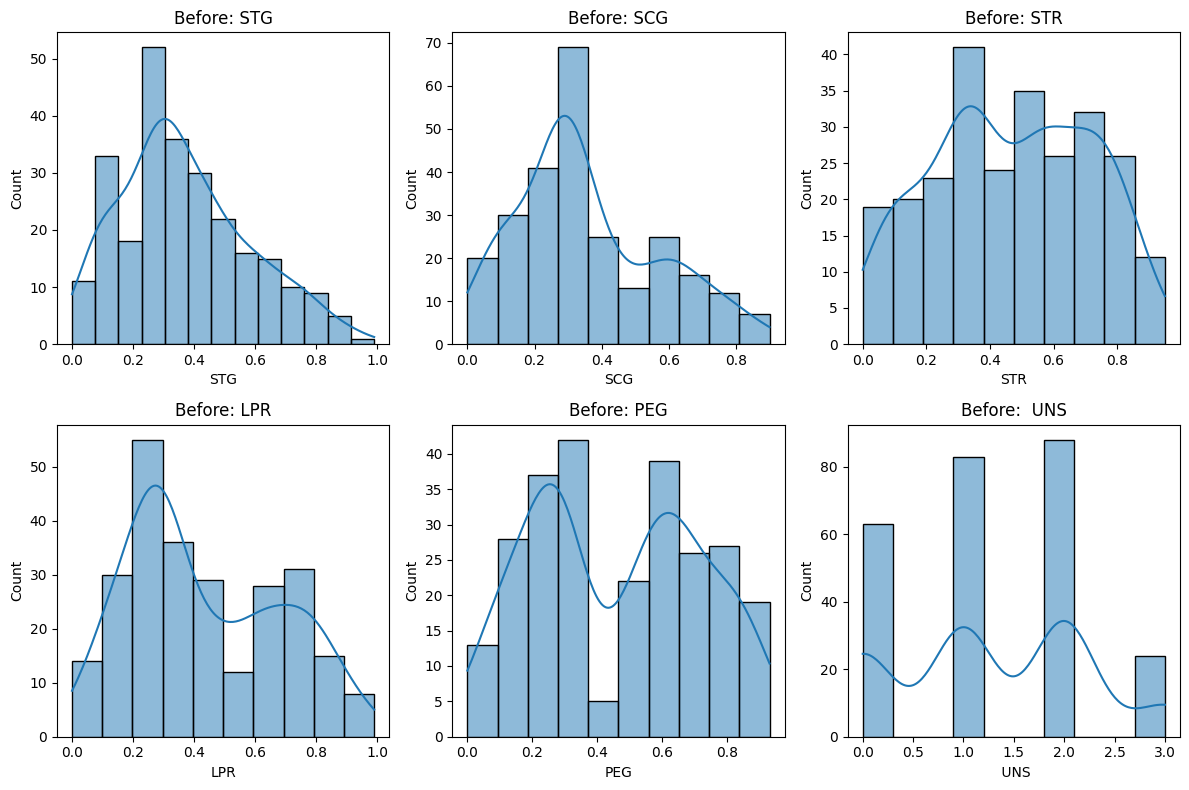

In [5]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, len(numeric_cols)//2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Before: {col}")
plt.tight_layout()
plt.show()

In [6]:
for col in numeric_cols:
    if abs(skew(df[col])) > 1:
        df[col] = np.log1p(df[col])


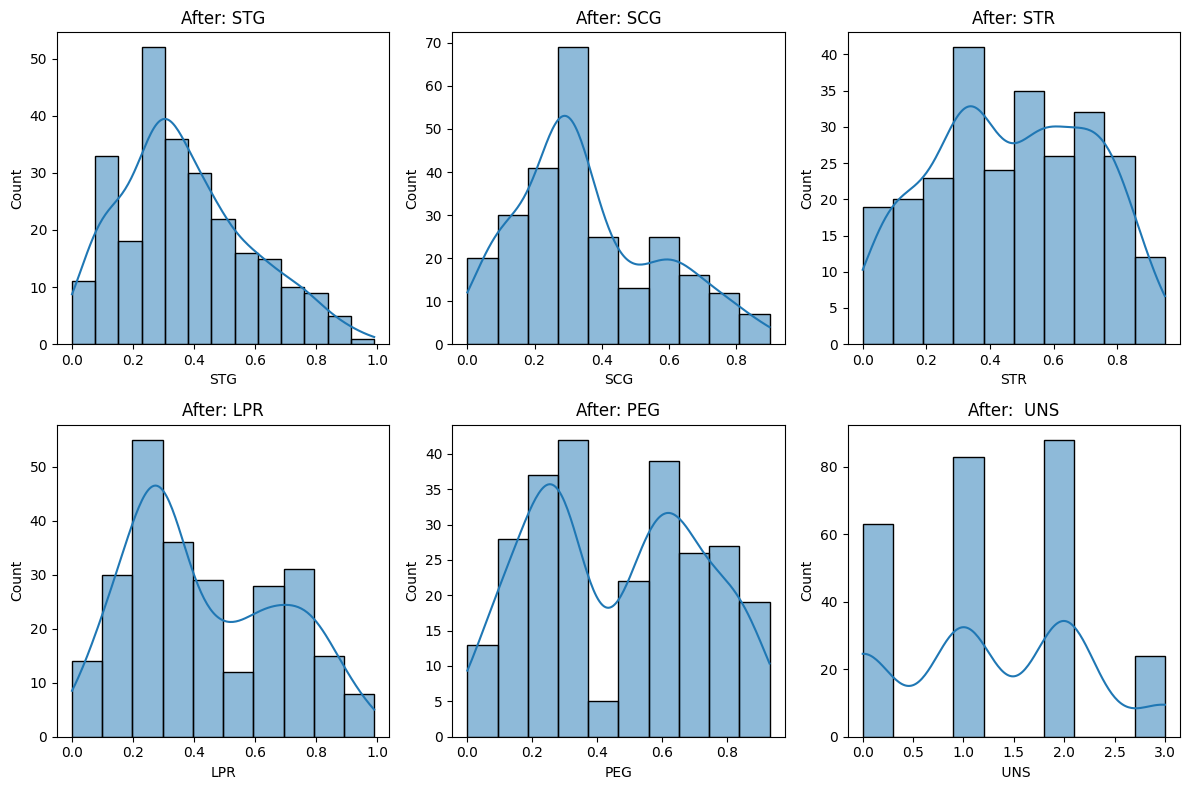

In [7]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, len(numeric_cols)//2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"After: {col}")
plt.tight_layout()
plt.show()


Outliers before: {'STG': np.int64(5), 'SCG': np.int64(0), 'STR': np.int64(0), 'LPR': np.int64(0), 'PEG': np.int64(0), ' UNS': np.int64(0)}


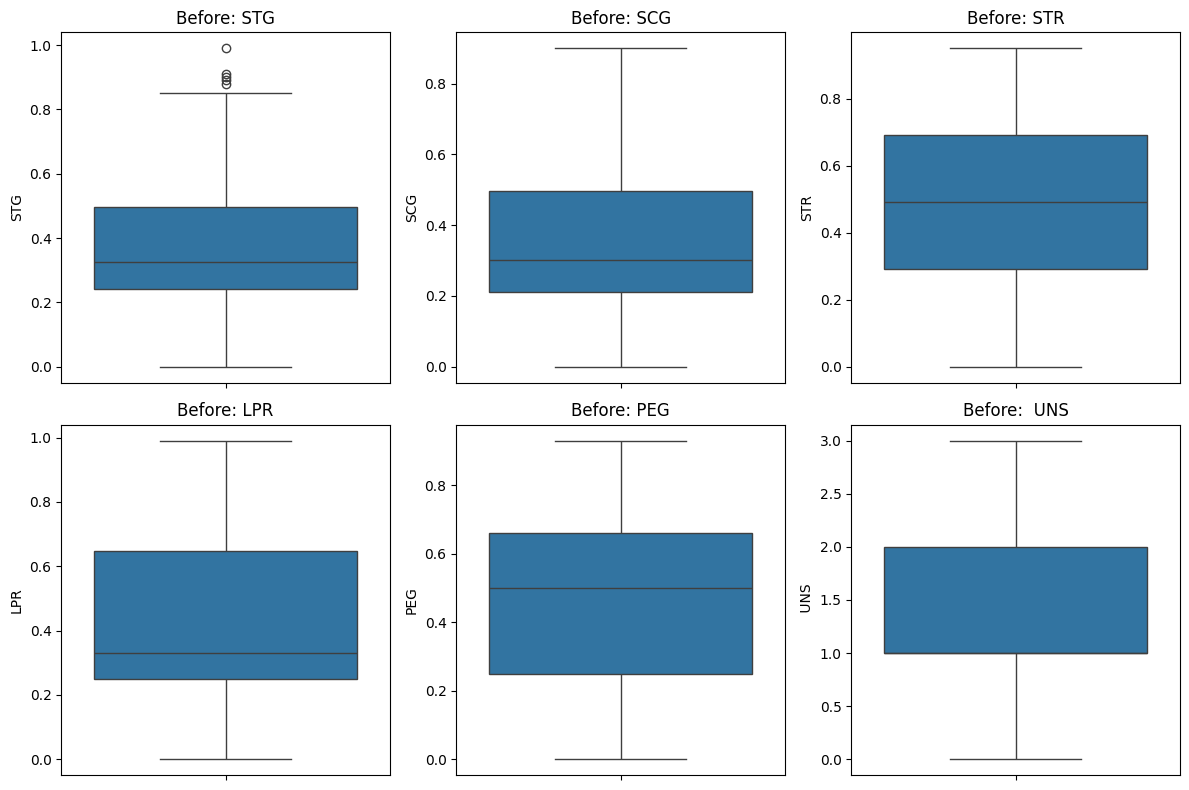

In [8]:
def count_outliers(series):
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

outliers_before = {col: count_outliers(df[col]) for col in numeric_cols}
print("\nOutliers before:", outliers_before)

# Before boxplot
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, len(numeric_cols)//2, i)
    sns.boxplot(df[col])
    plt.title(f"Before: {col}")
plt.tight_layout()
plt.show()


Outliers after: {'STG': np.int64(0), 'SCG': np.int64(0), 'STR': np.int64(0), 'LPR': np.int64(0), 'PEG': np.int64(0), ' UNS': np.int64(0)}


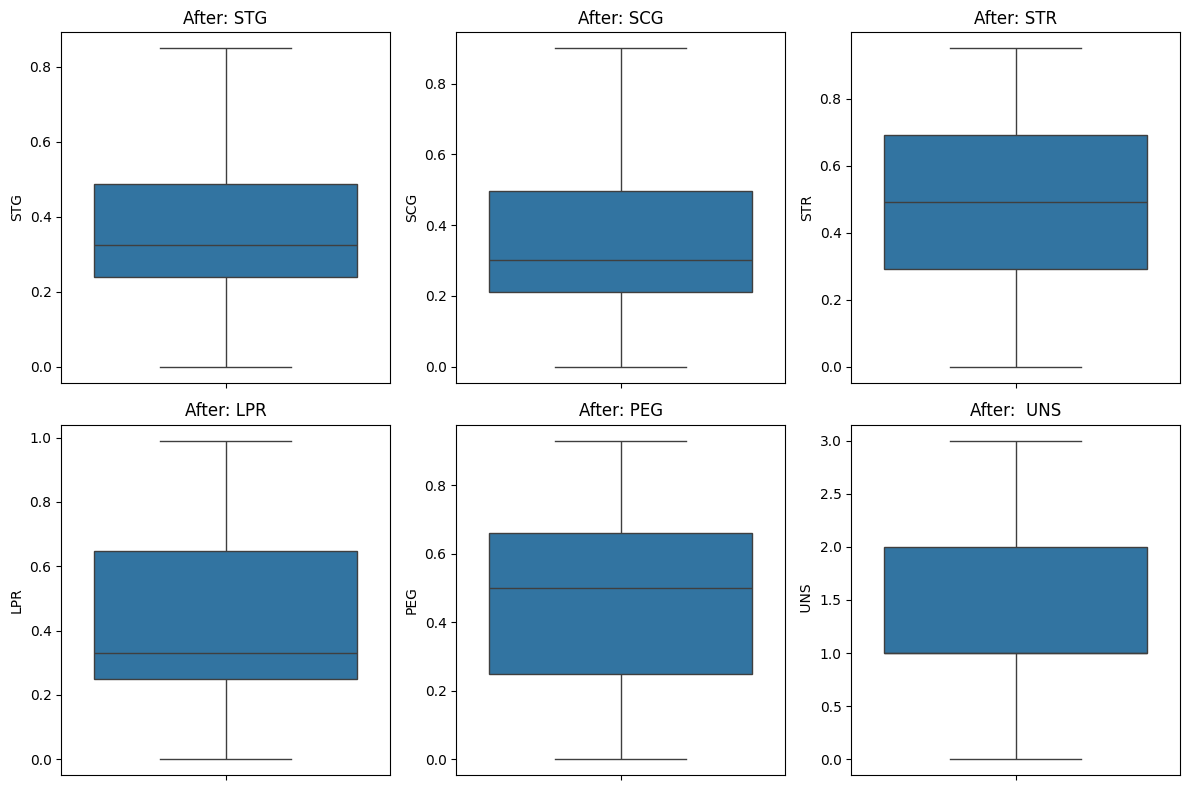

In [9]:
for col in numeric_cols:
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    median = df[col].median()
    df.loc[(df[col] < lower) | (df[col] > upper), col] = median

outliers_after = {col: count_outliers(df[col]) for col in numeric_cols}
print("\nOutliers after:", outliers_after)

# After boxplot
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, len(numeric_cols)//2, i)
    sns.boxplot(df[col])
    plt.title(f"After: {col}")
plt.tight_layout()
plt.show()


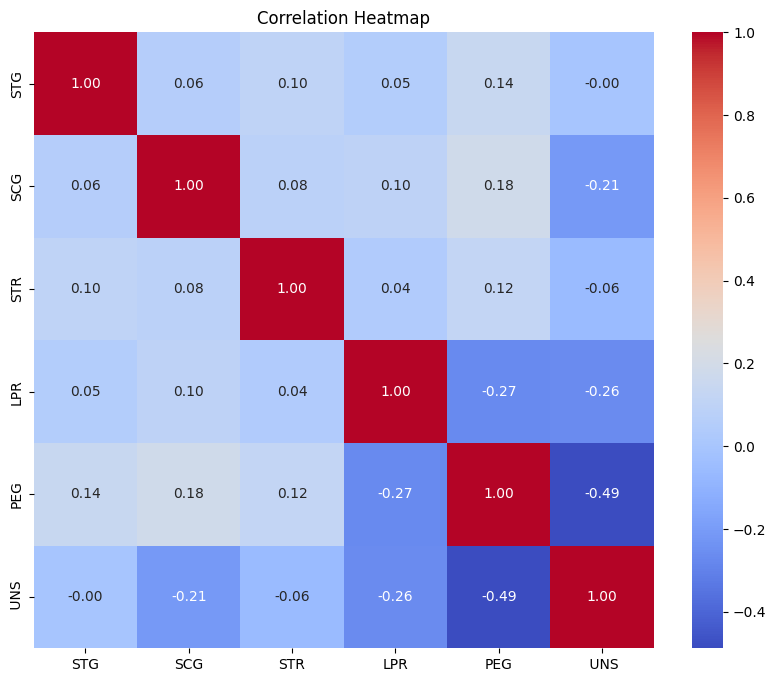

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [11]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
X = scaled_data


In [12]:
target_col = df.columns[-1]  # last column as target
X = df.drop(columns=[target_col])
y = df[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n=== Regression Results ===")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


=== Regression Results ===
R² Score: 0.813
RMSE: 0.451


In [13]:
print("\n=== Clustering ===")

# KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
sil_k = silhouette_score(X, kmeans_labels)
print(f"KMeans Silhouette Score: {sil_k:.3f}")

# Hierarchical
agg = AgglomerativeClustering(n_clusters=2)
agg_labels = agg.fit_predict(X)
sil_h = silhouette_score(X, agg_labels)
print(f"Agglomerative Silhouette Score: {sil_h:.3f}")

# DBSCAN
db = DBSCAN(eps=1.0, min_samples=5)
db_labels = db.fit_predict(X)
if len(set(db_labels)) > 1:
    sil_d = silhouette_score(X, db_labels)
else:
    sil_d = -1
print(f"DBSCAN Silhouette Score: {sil_d:.3f}")



=== Clustering ===
KMeans Silhouette Score: 0.218
Agglomerative Silhouette Score: 0.194
DBSCAN Silhouette Score: -1.000


In [14]:
results = pd.DataFrame({
    'Algorithm': ['KMeans', 'Agglomerative', 'DBSCAN'],
    'Silhouette': [sil_k, sil_h, sil_d]
})
print("\n=== Clustering Results ===")
print(results)

best = results.loc[results['Silhouette'].idxmax()]
print(f"\n✅ Best algorithm: {best.Algorithm} (Score: {best.Silhouette:.3f})")



=== Clustering Results ===
       Algorithm  Silhouette
0         KMeans    0.218328
1  Agglomerative    0.193583
2         DBSCAN   -1.000000

✅ Best algorithm: KMeans (Score: 0.218)


In [15]:
print("\n=== Clustering ===")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
sil_k = silhouette_score(X_scaled, kmeans_labels)
ari_k = adjusted_rand_score(pd.qcut(y, q=3, labels=False), kmeans_labels)
print(f"KMeans → Silhouette: {sil_k:.3f}, ARI: {ari_k:.3f}")

# Agglomerative
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_scaled)
sil_h = silhouette_score(X_scaled, agg_labels)
ari_h = adjusted_rand_score(pd.qcut(y, q=3, labels=False), agg_labels)
print(f"Agglomerative → Silhouette: {sil_h:.3f}, ARI: {ari_h:.3f}")

# DBSCAN
db = DBSCAN(eps=0.8, min_samples=5)
db_labels = db.fit_predict(X_scaled)
if len(set(db_labels)) > 1:
    sil_d = silhouette_score(X_scaled, db_labels)
    ari_d = adjusted_rand_score(pd.qcut(y, q=3, labels=False), db_labels)
else:
    sil_d, ari_d = -1, -1
print(f"DBSCAN → Silhouette: {sil_d:.3f}, ARI: {ari_d:.3f}")


=== Clustering ===
KMeans → Silhouette: 0.185, ARI: 0.090
Agglomerative → Silhouette: 0.149, ARI: 0.054
DBSCAN → Silhouette: -0.254, ARI: 0.045


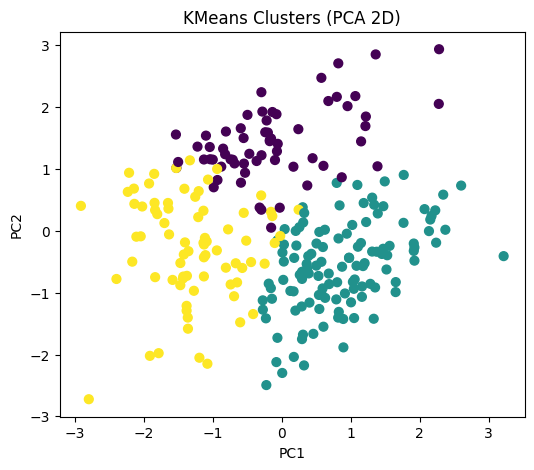

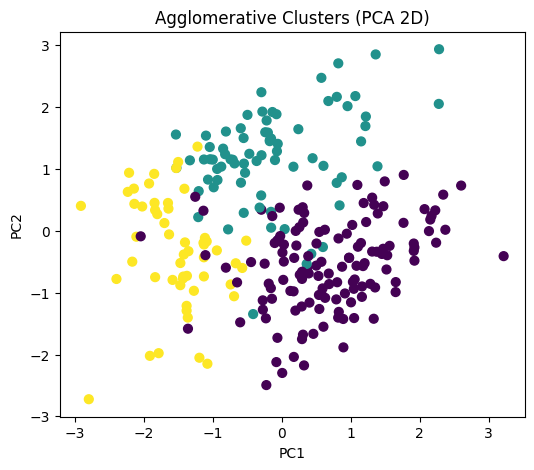

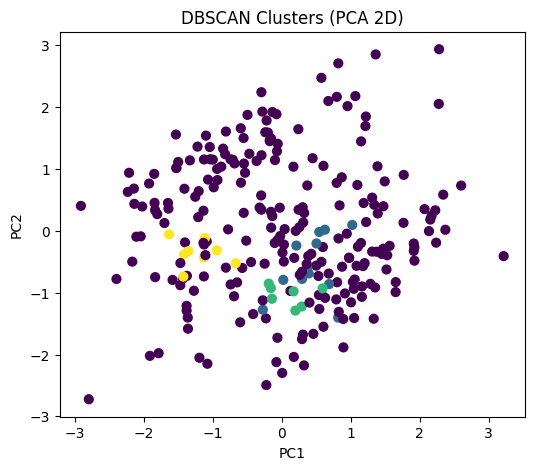

In [16]:
def plot_clusters(X_2d, labels, title):
    plt.figure(figsize=(6,5))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='viridis', s=40)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_clusters(X_pca, kmeans_labels, "KMeans Clusters (PCA 2D)")
plot_clusters(X_pca, agg_labels, "Agglomerative Clusters (PCA 2D)")
plot_clusters(X_pca, db_labels, "DBSCAN Clusters (PCA 2D)")


In [17]:
# Step 10: Compare
results = pd.DataFrame({
    'Algorithm': ['KMeans', 'Agglomerative', 'DBSCAN'],
    'Silhouette': [sil_k, sil_h, sil_d],
    'ARI': [ari_k, ari_h, ari_d]
})
print("\n=== Clustering Comparison ===")
print(results)

best = results.loc[results['Silhouette'].idxmax()]
print(f"\n✅ Best Algorithm: {best.Algorithm} (Silhouette={best.Silhouette:.3f}, ARI={best.ARI:.3f})")


=== Clustering Comparison ===
       Algorithm  Silhouette       ARI
0         KMeans    0.184777  0.089734
1  Agglomerative    0.149059  0.054086
2         DBSCAN   -0.254382  0.045352

✅ Best Algorithm: KMeans (Silhouette=0.185, ARI=0.090)
